[Mask R-CNN paper](https://arxiv.org/abs/1703.06870)  

[Pytoch model example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

# **1. Dataset**

In [ ]:
# --- Install pycocotools, the version by default in Colab

%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-sbdnlk_g
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-sbdnlk_g
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263900 sha256=dd6fae247a531be4fa0ddc53d4da181669df190d81431bd0e28f3cc4713fcf1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vk8a72i6/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=5377fd66d2377e6bd84c44ea5e7b4135f74276082edd1435e68b5341500b64de
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 118.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
# --- mount drive
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader as gdd
use_drive = False

if (use_drive):
  drive.mount('/content/drive')
else:
  # threshold: 18%
  # total: 80256 - ignored: 76.563 - useful: 3.693
  # 2954 / 369 / 369 + 3%
  # train/val/test: 3045/381/378
  gdd.download_file_from_google_drive(file_id='1YCauBS9BxFJZE1sJbGT1XDElAop37peW',
                                      dest_path='./hedychium_coronarium.zip',
                                      unzip=True)

Unzipping...Done.


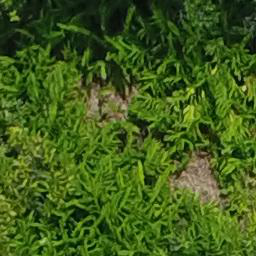

In [ ]:
# --- Image example
from PIL import Image, ImageOps

if (use_drive):
  data_path = '/content/drive/MyDrive/Colab Notebooks/Robotica/Lirio do Brejo/'
  img_example_path = 'train/images/DJI_0250_part_62.JPG'  
else:
  data_path = '/content/hedychium_coronarium/'
  img_example_path = 'train/images/DJI_0127_part_50.JPG'

Image.open(data_path + img_example_path)

In [ ]:
# --- preprocess the mask image to convert the values from [0; 255] to [0; 1]:

import matplotlib.pyplot as plt
import numpy as np

def maskBinarization(img):
    img_arr = np.asarray(img)/1.0
    return img_arr

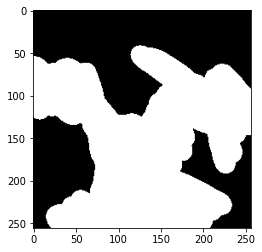

In [ ]:
# --- Mask example
if (use_drive):
  mask_img = Image.open(data_path + 'train/masks/DJI_0250_part_62.JPG').convert("1")
else:
  mask_img = Image.open(data_path + 'train/masks/DJI_0127_part_50.JPG').convert("1")

plt.imshow(mask_img)
plt.show()

In [ ]:
i = maskBinarization(mask_img)

In [ ]:
np.unique(i)

array([0., 1.])

In [ ]:
i.shape

(256, 256)

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import random

class LirioDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        qty_max_of_samples = 5000

        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

        # reduces dataset size to speed up the train...
        if ( qty_max_of_samples >= len(self.imgs) ):
          qty_max_of_samples = len(self.imgs) - 1

        print(f'Using {qty_max_of_samples}/{len(self.imgs) - 1} images')

        self.imgs = self.imgs[:qty_max_of_samples]
        self.masks = self.masks[:qty_max_of_samples]


    def __getitem__(self, idx):
        # load images and masks

        # bugfix
        # if (idx < 0 or idx >= len(self.imgs)):
        #   new_idx = random.randint(0, len(self.imgs)-1)
        #   print(f'{self.root}/images/ - idx:{idx} - new_idx: {new_idx} - len of dataset:{len(self.imgs)}')
        #   idx = new_idx


        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        mask_img = Image.open(mask_path).convert("1")
        mask = maskBinarization(mask_img)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # -----
        if len(obj_ids)>1:
               
            # first id is the background, so remove it
            obj_ids = obj_ids[1:]

            # split the color-encoded mask into a set of binary masks
            masks = mask == obj_ids[:, None, None]

            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
            # suppose all instances are not crowd
            #iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            # suppose all instances ARE crowd
            iscrowd = torch.ones((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target
        
        
        # -----
        elif len(obj_ids)>0:
               
            # first id is the background, so remove it
            # obj_ids = obj_ids[1:]

            # split the color-encoded mask into a set of binary masks
            masks = mask == obj_ids[:, None, None]

            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = [[0., 0., mask.shape[0], mask.shape[1]]]

            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
            # suppose all instances are not crowd
            #iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            # suppose all instances ARE crowd
            iscrowd = torch.ones((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target
        
        # -----
        else: #len(obj_ids)==0
               
            # first id is the background, so remove it
            # obj_ids = obj_ids[1:]

            # split the color-encoded mask into a set of binary masks
            masks = mask == obj_ids[:, None, None]

            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = [[0., 0., 0., 0.]]

            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
            # suppose all instances are not crowd
            #iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            # suppose all instances ARE crowd
            iscrowd = torch.ones((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target


    def __len__(self):
        return len(self.imgs)

In [ ]:
# --- the dataset returns a `PIL.Image` and a dictionary containing several fields,
# including "boxes", "labels" and "masks"

cwd = data_path + r'train/'
dataset = LirioDataset(cwd)

dataset[0]

Using 3044/3044 images


(<PIL.Image.Image image mode=RGB size=256x256 at 0x7EFF1A7F9110>,
 {'area': tensor([54570.]),
  'boxes': tensor([[  0.,  41., 255., 255.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([1]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [ ]:
# d = iter(dataset)

In [ ]:
# im, tg = next(d)
# img=im.numpy().transpose(1, 2, 0).copy()

In [ ]:
# import cv2

# img, tg = dataset[0]

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])

# img = np.ascontiguousarray(img)

# boxes = tg["boxes"]
# print("len(boxes)", len(boxes))

# for b in boxes:  
#     cv2.rectangle(img, 
#                  ( int(b[0]), int(b[1]) ), 
#                  ( int(b[2]), int(b[3]) ), 
#                  (0,0,255), 
#                  2)
     
# ax.imshow(img, vmin=0, vmax=255)
# ax.set_axis_off()

# plt.show()

# **2. Model definition**

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# **3. Data Augmentation**

In [ ]:
%%shell

# Download TorchVision repo to use some files from references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 33821, done.
remote: Counting objects: 100% (6363/6363), done.
remote: Compressing objects: 100% (1286/1286), done.
remote: Total 33821 (delta 5098), reused 6105 (delta 4951), pack-reused 27458
Receiving objects: 100% (33821/33821), 43.94 MiB | 31.64 MiB/s, done.
Resolving deltas: 100% (25713/25713), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# **4. Model and optimizer instantiation**

In [ ]:
cwd_train = data_path + r"train/"
cwd_test = data_path + r"test/"

# use our dataset and defined transformations
dataset = LirioDataset(cwd_train, get_transform(train=True))
dataset_test = LirioDataset(cwd_test, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# qty = len(indices)
# train_size = round(qty * 0.8)
# test_size = qty - train_size
# print(f'total: {qty} - train/test: {train_size}/{test_size}')

#dataset = torch.utils.data.Subset(dataset, indices[:-train_size])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_size:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Using 3044/3044 images
Using 377/377 images


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.05,
                            momentum=0.9,
                            weight_decay=0.05)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [  0/191]  eta: 0:06:26  lr: 0.000313  loss: 6.9493 (6.9493)  loss_classifier: 0.3653 (0.3653)  loss_box_reg: 0.1078 (0.1078)  loss_mask: 6.4325 (6.4325)  loss_objectness: 0.0327 (0.0327)  loss_rpn_box_reg: 0.0110 (0.0110)  time: 2.0227  data: 0.2513  max mem: 11308
Epoch: [0]  [ 10/191]  eta: 0:04:57  lr: 0.002942  loss: 1.1956 (2.2269)  loss_classifier: 0.0933 (0.1619)  loss_box_reg: 0.0618 (0.0643)  loss_mask: 0.9804 (1.9211)  loss_objectness: 0.0403 (0.0574)  loss_rpn_box_reg: 0.0215 (0.0222)  time: 1.6409  data: 0.0545  max mem: 11578
Epoch: [0]  [ 20/191]  eta: 0:04:38  lr: 0.005571  loss: 0.8823 (1.5714)  loss_classifier: 0.0558 (0.1122)  loss_box_reg: 0.0874 (0.0810)  loss_mask: 0.6669 (1.3154)  loss_objectness: 0.0315 (0.0433)  loss_rpn_box_reg: 0.0181 (0.0194)  time: 1.6108  data: 0.0356  max mem: 11578
Epoch: [0]  [ 30/191]  eta: 0:04:21  lr: 0.008200  loss: 0.8286 (1.3327)  loss_classifier: 0.0461 (0.0903)  loss_box_reg: 0.0922 (0.0814)  loss_mask: 0.6508 (1.105

# **5.Predictions**

In [ ]:
# pick one image from the test set
img, _ = dataset_test[1]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[  0.0000,  16.5223, 238.9588, 178.8836],
          [  0.0000,  75.1420, 256.0000, 237.3841],
          [ 72.8463,   0.0000, 238.9595, 256.0000],
          [ 20.4845,   0.0000, 253.7347, 109.8754],
          [  0.0000,   0.0000, 110.5337, 214.9291],
          [  0.0000, 122.3976, 193.4614, 256.0000]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
  
  
          [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.00

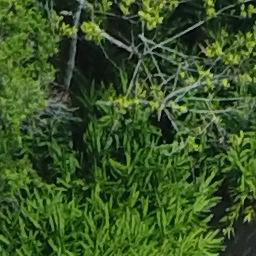

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

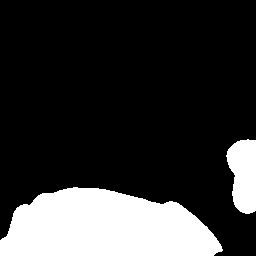

In [ ]:
img, _ = dataset_test[1]
arr = _['masks'].cpu().detach().numpy()
#print(arr.shape)
#print(arr[0,:,:])
Image.fromarray(arr[0,:,:])

from matplotlib import pyplot
x = _['masks'].numpy() * 255
Image.fromarray(x[0,:,:])


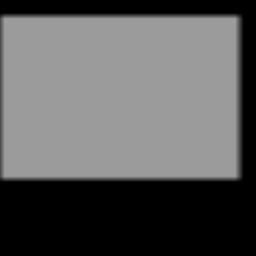

In [ ]:
predict = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
Image.fromarray(predict)

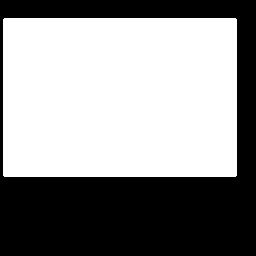

In [ ]:
predict[predict<=127.5] = 0
predict[predict>127.5] = 255

Image.fromarray(predict)

In [ ]:
torch.save(model.state_dict(), 'pesos.pt')